Code to simulate Fibre Bragg Grating  
Written by: Samhita Sodhi

This notebook contains code which loads spectra data of a particular gas and simulates Fibre Bragg Grating stretching/strain.  
Currently using Nicholas' data from SAIL labs to test and write the functions. 

Notes from the author:
- Nicholas' acetylene data does not appear to be the same as the spectra produced by NASA PSG https://psg.gsfc.nasa.gov/
- Code is written such that data files need to be loaded in, eg. gas and fibre bragg grating 
- Code has been checked to work with NASA PSG data files and Nicholas' SAIL lab files -- may need to edit if data format is changed 
- Formula for Gaussian used: amp*1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x - mu)^2/(2*sigma^2)) source: https://www.geeksforgeeks.org/python-gaussian-fit/ , https://www.tutorialspoint.com/gaussian-fit-using-python, https://stackoverflow.com/questions/19206332/gaussian-fit-for-python
- Formula for Lorentzian used: (amp/np.pi) * (sigma/((x-mu)^2 + sigma^2)) source: 
- The functions include: 
    - input_spectra, 
    - plot_spectra, 
    - fit_curves, 
    - blackbodyabsorption, 
    - simulate_strain, 
    - plot_total_light
    - convert_fluxunits_to_photoncounts
- The purpose of the function num_strain() is motivated by Nicholas' thesis plots on pg.13


Issues
- Need to find appropriate lineshapes as lorentzian/gaussian don't fit data -- try voigt with equation from HITRAN https://hitran.org/docs/definitions-and-units/,  https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.voigt_profile.html. Three methods of doing Voigt fitting - either convolve a Gaussian and Lorentzian, find a Voigt function online or write an equation http://emilygraceripka.com/blog/16
- The function which fits a Gaussian or Lorentzian to each peak uses a hardcoded "width value" which appears to work for the data I have worked with but may need to be looked into, there is a variable which contains the widths for each peak but does not appear to work
- Blackbody function converts the units into Angstroms because I was unsure about the units that astropy BlackBody requires as an input
- Function that simulates the straining of the fibre bragg grating carried a bug which showed overfitting at the boundary (particularly for shorter wavelengths), this is likely due to extrapolation overfitting values at the boundary since it only had data from one side, this was corrected using bound_error = 'false' https://docs.scipy.org/doc/scipy/tutorial/interpolate/extrapolation_examples.html, https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html
- Theoretical modelling only uses blackbody -- improve by adding model for sunlight, whitelight, laser 
- When adding photon noise perhaps try Poisson noise rather than Gaussian noise as was used in Nicholas' code
- sim_stretch works well for strains between XXe-4 to XXe-6

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
from astropy import units as u
from astropy import constants as const
from astropy.modeling.models import BlackBody
from scipy.signal import find_peaks
from scipy.interpolate import interp1d

**Preparing the input spectral data**

In [2]:
def input_spectra(filepath, isheader, separation, wavelengthunits, wavelengthcol, dataunits, datacol):
    """
    This function loads in the datafile for the spectral information and assigns values to the wavelength and spectral data.
    
    Parameters include:
        - filepath                  : input file with at least one column for wavelength given in nanometers (nm) or micrometres (um)
                                      and one column for spectral line intensity. Needs to be contained within "".  
        - isheader                  : parameter takes in whether there is a header in the file. None means there is no header present
        - separation                : parameter takes in what the separation between the variables within the file
                                      e.g. "\t" means values separated by a tab
        - wavelengthunits           : enter the units of the wavelength data, input "um" or "nm", function will convert units into um. 
        - wavelengthcol             : user inputs which column consists of the wavelength values
        - dataunits                 : enter the units of the spectral data, input "fractional" or "dB", function will convert value to 
                                      a fractional value between 0 and 1 
        - datacol                   : user inputs which column consists of the spectra data values
        - gas_wavelength            : variable consisting of the wavelength data
        - gas_absorption_line_data  : variable consisting of the gas absorption data
    """

    # ~~~~~ Inputs the data file
    gas_raw_data = pd.read_csv(filepath, header = isheader, sep = separation).values #stores the file into a variable 
    gas_wavelength = (gas_raw_data[:,wavelengthcol]).astype(float) #variable stores the wavelength range
    gas_line_data = (gas_raw_data[:,datacol]).astype(float) #variable stores the absorption line data for each line 
        
    if wavelengthunits == "um":
        gas_wavelength = gas_wavelength #leaves the wavelength units in micrometres (um)
    elif wavelengthunits == "nm": 
        gas_wavelength = (gas_wavelength/1000.0) #converts the wavelength units into micrometres (um)
    else:
        print("Please input the wavelength as um or nm")  

    if dataunits == "fractional": 
        gas_line_data = gas_line_data #leaves the data in terms of percentage
    elif dataunits == "dB":
        gas_line_data = (10**(gas_line_data/10))  #converts from decibels to a fractional value between 0 and 1
    else: 
        print("Please input dB or percentage")

    fibre_raw_data = pd.read_csv(filepath, header = isheader, sep = separation).values #stores the file into a variable 
    fibre_wavelength = (fibre_raw_data[:,wavelengthcol]).astype(float) #variable stores the wavelength range
    fibregrating_line_data = (fibre_raw_data[:,datacol]).astype(float) #variable stores the absorption line data for each line 
            
    if wavelengthunits == "um":
        fibre_wavelength = fibre_wavelength #leaves the wavelength units in micrometres (um)
    elif wavelengthunits == "nm": 
        fibre_wavelength = (fibre_wavelength/1000.0) #converts the wavelength units into micrometres (um)
    else:
        print("Please input the wavelength as um or nm")  

    if dataunits == "fractional": 
        fibregrating_line_data = fibregrating_line_data #leaves the data in terms of percentage
    elif dataunits == "dB":
        fibregrating_line_data = (10**(fibregrating_line_data/10))  #converts from decibels to a fractional value between 0 and 1
    else: 
        print("Please input dB or percentage")

    return gas_wavelength, gas_line_data

In [3]:
#Testing function using generated data from NASA PSG
spectra_wav, spectra_data = input_spectra('/home/samhitasodhi/Gas Sensor Project/Code - Nicholas Morley/fbg_prog/fbg_prog/Line_Lists/C2H2 gas cell-_40nm_1_T_C33-c2h2200C3M_42nm_0_T.txt', None, '\t', 'nm', 0, 'dB', 2)

In [4]:
def plot_spectra(name, spectra_wav, spectra_data, xlimits, ylimits):
   """
   This function provides a plotting facility for the input gas data file as a simple line graph, with wavelength and transmittance. 
   The y-axis corresponds to 1 being, light is 100% transmitted. 

   The parameters include: 
      - name            : input requires the name of the gas to be in the title of the plot, 
                          i.e., 'carbon dioxide gas' or 'carbon dioxide fibre bragg grating'
      - spectra_wav     : loads in the wavelengths 
      - spectra_data    : loads in the spectral data  
      - xlimits         : user has a choice to input a range of x values (wavelength) i.e.,  [ , ] for the plot
      - ylimits         : user has a choice to input a range of y values (Transmitted Intensity) i.e.,  [ , ] for the plot
   """

   gas_wavelength = spectra_wav
   gas_absorption_line_data = spectra_data

   if xlimits is not None or ylimits is not None: 
      # ~~~~~ Plot with custom limits
      plt.figure(figsize=(15, 4))
      plt.plot(gas_wavelength, gas_absorption_line_data)
      plt.xlim(xlimits)
      plt.ylim(ylimits)
      plt.title('Transmittance spectrum of ' + name)
      plt.xlabel('Wavelength (um)')
      plt.ylabel('Transmittance')
      plt.show()
   else: 
      # ~~~~~ Plot without custom limits
      plt.figure(figsize=(15, 4))
      plt.plot(gas_wavelength, gas_absorption_line_data)
      plt.title('Transmittance spectrum of ' + name)
      plt.xlabel('Wavelength (um)')
      plt.ylabel('Transmittance')
      plt.show()

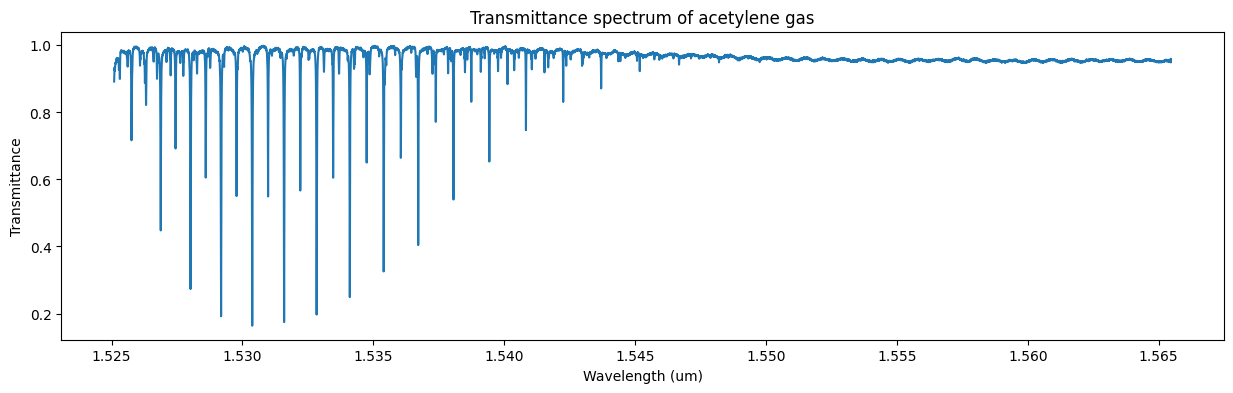

In [5]:
#Testing plot function
plot_spectra('acetylene gas', spectra_wav, spectra_data, None, None)

In [6]:
def fit_curves(spectra_wav, spectra_data, detection_height, xlimits, ylimits, model):
    """
    This function first detects peaks for the spectral data by reversing the values, and then plots a model - either Lorentzian 
    or a Gaussian - for each of the peaks of the input gas data whilst converting it back to the default spectrum appearance. 
    
    The parameters include: 
      - spectra_wav     : loads in the wavelengths 
      - spectra_data    : loads in the spectral data  
      - detection_height: input a value for the height of a spectral line to classify as a peak i.e., a value of 0.01 means 
                          any spectral line smaller than this value will not be classified as a peak. Please note: overfitting 
                          or underfitting may occur if the value inputted is too large or too small
      - xlimits         : user has a choice to input a range of x values (wavelength) i.e.,  [ , ] for the plot
      - ylimits         : user has a choice to input a range of y values (Transmitted Intensity) i.e.,  [ , ] for the plot
      - model           : choose to either fit a 'gaussian' or a 'lorentzian' curve to the data
   """
    
    # ~~~~~~~~ DETECTING PEAKS ~~~~~~~~
    x_values = np.array(spectra_wav)
    y_values = np.array(1.0 - spectra_data) # flipping the graph so peak detection can occur

    peaks, properties = find_peaks(y_values, height= detection_height, width = 0) #properties include, peak heights, peak widths, etc. 
     
    # PLOTS DETECTED PEAKS
    if xlimits is not None or ylimits is not None: 
        # Plot with custom limits
        figure(figsize=(15, 4))
        plt.plot(x_values, y_values)
        plt.plot(x_values[peaks], y_values[peaks], "x")
        plt.xlim(xlimits)
        plt.ylim(ylimits)
        plt.xlabel('Wavelength (um)')
        plt.ylabel('Absorption')
        plt.title('Visualise detected peaks')
        plt.show()
    else:
        # Plot without custom limits
        figure(figsize=(15, 4))
        plt.plot(x_values, y_values)
        plt.plot(x_values[peaks], y_values[peaks], "x")
        plt.xlabel('Wavelength (um)')
        plt.ylabel('Absorption')
        plt.title('Visualise detected peaks')
        plt.show()

    # ~~~~~~~~ FITS GAUSSIAN OR LORENTZIAN MODELS TO THE DATA AND PLOTS THEM ~~~~~~~~
    # ~~~~~~~~ GAUSSIAN MODEL ~~~~~~~~
    if model == 'gaussian': 
        def gaussian(x, sigma, mu, amp):
            return amp*1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x - mu)**2/(2*sigma**2))     # equation for gaussian model

        peak = np.array(x_values[peaks]) #since peaks is an array of indexes, associating each index to it's wavelength value
        #widths = np.array(properties['widths']) #array of all the widths found by find_peaks
        widths = 0.00001 #using a hardcoded/random width instead (!!)
        amps = np.array(properties['peak_heights']) #array of all the heights found by find_peaks

        x = np.array(spectra_wav)
        y_g = np.zeros(x.shape) 

        for i in range(len(peaks)): #for each peak in the range of the length of the number of peaks... 
            g = gaussian(x, sigma=widths, mu=peak[i], amp=amps[i]) #...fit this gaussian
            y_g += g

        # fitting a gaussian changes the y value due to a normalisation process, thus to change it back to it's original value
        # a scale variable is created 
        scale = max(y_g)/max(properties['peak_heights'])
        amps_scaled = np.array(properties['peak_heights']) / scale #array of all the heights scaled down to the actual values

        y_gscaled = np.zeros(x.shape) 

        for i in range(len(peaks)): #for each peak in the range of the length of the number of peaks... 
            g = gaussian(x, sigma=widths, mu=peak[i], amp=amps_scaled[i]) #...fit this gaussian
            y_gscaled += g

        transmittance = 1 - y_gscaled    #this variable will allow a plot of the transmittance with the y-axis scaled down

        # PLOTTING 
        if xlimits is not None or ylimits is not None:
            # Plot with custom limits
            figure(figsize=(15, 4))
            plt.plot(x, transmittance, color = 'y')
            plt.xlim(xlimits)
            plt.ylim(ylimits)
            plt.xlabel('Wavelength (um)')
            plt.ylabel('Transmittance')
            plt.title('Fitting a Gaussian to the spectrum')
            plt.legend(['Gaussian fitted spectrum'])
            plt.show()
        else: 
            # Plot without custom limits
            figure(figsize=(15, 4))
            plt.plot(x, transmittance, color = 'y')
            plt.xlabel('Wavelength (um)')
            plt.ylabel('Transmittance')
            plt.title('Fitting a Gaussian to the spectrum')
            plt.legend(['Gaussian fitted spectrum'])
            plt.show()

    # ~~~~~~~~ LORENTZIAN MODEL ~~~~~~~~
    elif model == 'lorentzian':
        def lorentzian(x, sigma, mu, amp):
            return (amp/np.pi) * (sigma/((x-mu)**2 + sigma**2))     # equation for lorentzian model

        peak = np.array(x_values[peaks])  #since peaks is an array of indexes, associating each index to it's wavelength value
        #widths = np.array(properties['widths'])  #array of all the widths found by find_peaks
        widths = 0.00001 #using a hardcoded/random width instead (!!)
        amps = np.array(properties['peak_heights']) #array of all the heights found by find_peaks
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
        x = np.array(spectra_wav)
        y_l = np.zeros(x.shape) 

        for i in range(len(peaks)): #for each peak in the range of the length of the number of peaks...
            lor = lorentzian(x, sigma=widths, mu=peak[i], amp=amps[i]) #...fit this lorentzian
            y_l += lor

        # fitting a gaussian changes the y value due to a normalisation process, thus to change it back to it's original value
        # a scale variable is created 

        scale = max(y_l)/max(properties['peak_heights'])
        amps_scaled = np.array(properties['peak_heights']) / scale #array of all the heights

        y_lscaled = np.zeros(x.shape) 

        for i in range(len(peaks)): #for each peak in the range of the length of the number of peaks...
            lor = lorentzian(x, sigma=widths, mu=peak[i], amp=amps_scaled[i]) #...fit this lorentzian
            y_lscaled += lor

        transmittance = 1 - y_lscaled       #this variable will allow a plot of the transmittance with the y-axis scaled down
        
        # PLOTTING
        if xlimits is not None or ylimits is not None:  
            # Plot with custom limits
            figure(figsize=(15, 4))
            plt.plot(x, transmittance)
            plt.xlim(xlimits)
            plt.ylim(ylimits)
            plt.xlabel('Wavelength (um)')
            plt.ylabel('Transmittance')
            plt.title('Fitting a Lorentzian to the spectrum')
            plt.legend(['Lorentzian fitted spectrum'])
            plt.show()
        else: 
            # Plot without custom limits
            figure(figsize=(15, 4))
            plt.plot(x, transmittance)
            plt.xlabel('Wavelength (um)')
            plt.ylabel('Transmittance')
            plt.title('Fitting a Lorentzian to the spectrum')
            plt.legend(['Lorentzian fitted spectrum'])
            plt.show()

    return transmittance

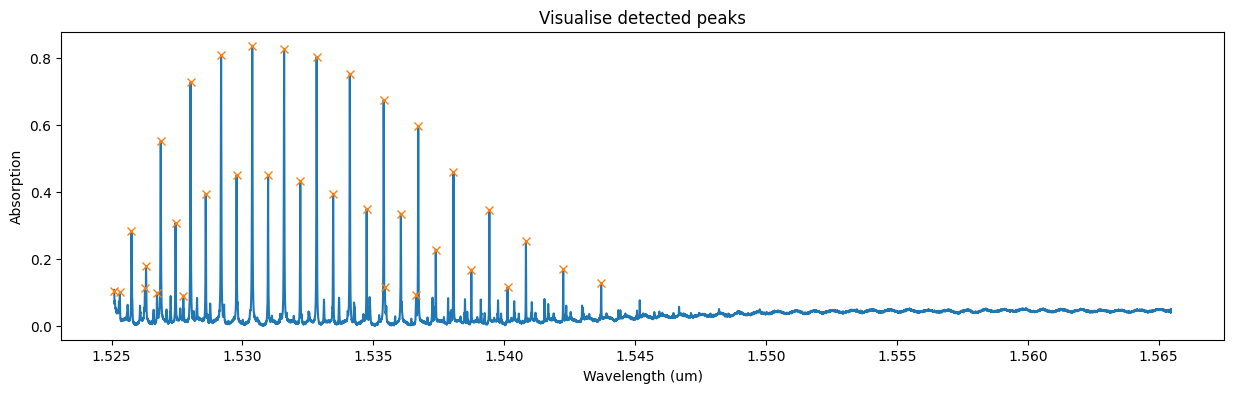

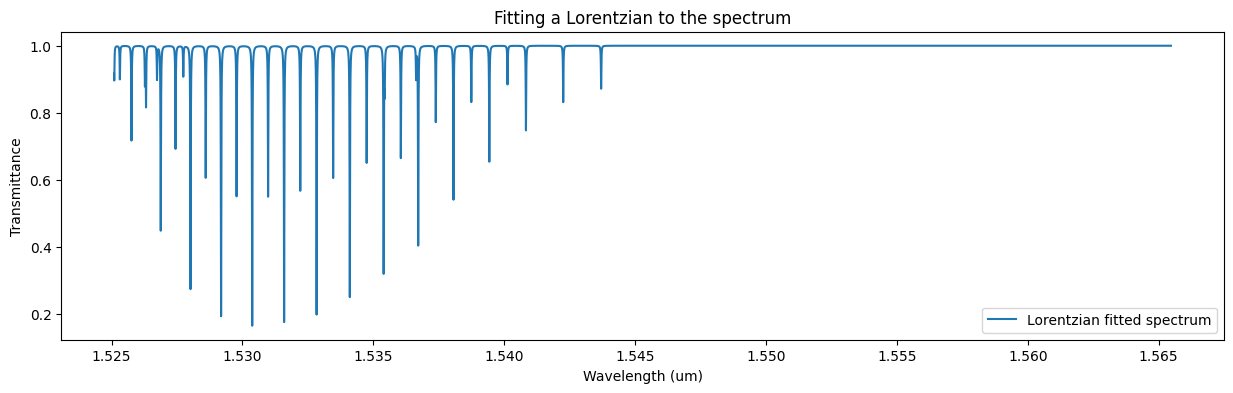

In [7]:
#Testing function
transmittance = fit_curves(spectra_wav, spectra_data, 0.09, None, None, 'lorentzian')

In [8]:
def blackbodyabsorption(name, wavelength, spectra_data, temp, xlimits, ylimits): 
   """
   Function returns a theoretical blackbody radiation curve at the chosen temperature with the absorption of the provided gas. 

   The parameters include: 
      - name                  : input requires the name of the gas to be in the title of the plot, 
                                i.e., 'carbon dioxide gas' or 'carbon dioxide fibre bragg grating'      
      - wavelength            : loads in the wavelengths
      - spectra_data          : loads in the spectral data
      - temp                  : temperature of the blackbody
      - xlimits               : user has a choice to input a range of x values (wavelength) i.e.,  [ , ] for the plot
      - ylimits               : user has a choice to input a range of y values (Transmitted Intensity) i.e.,  [ , ] for the plot
   """

   bb = BlackBody(temperature = temp*u.K)
   wavelength_units = (wavelength*10000)*(u.AA) #confusion regarding the units until cleared leaving it as angstrom (!!)
   flux = bb(wavelength_units) #consists of the calculated blackbody flux for the given wavelengths
   transmittance = spectra_data
   transmitted_intensity = transmittance*flux #consists of the absorption applied to a blackbody of given temperature 
 
   if xlimits is not None or ylimits is not None: 
      # Plot with custom limits
      plt.figure(figsize=(15, 4))
      plt.plot(wavelength, transmitted_intensity)
      plt.xlim(xlimits)
      plt.ylim(ylimits)
      plt.title('Blackbody radiation spectrum of' + ' ' + name)
      plt.xlabel('Wavelength (um)')
      plt.ylabel('Transmitted Intensity (erg / cm2 Hz s sr)')
      plt.show()
   else: 
      # Plot without custom limits
      plt.figure(figsize=(15, 4))
      plt.plot(wavelength, transmitted_intensity)
      plt.title('Blackbody radiation spectrum of' + ' ' + name)
      plt.xlabel('Wavelength (um)')
      plt.ylabel('Transmitted Intensity (erg / cm2 Hz s sr)')
      plt.show()
      
      
   return flux, transmitted_intensity

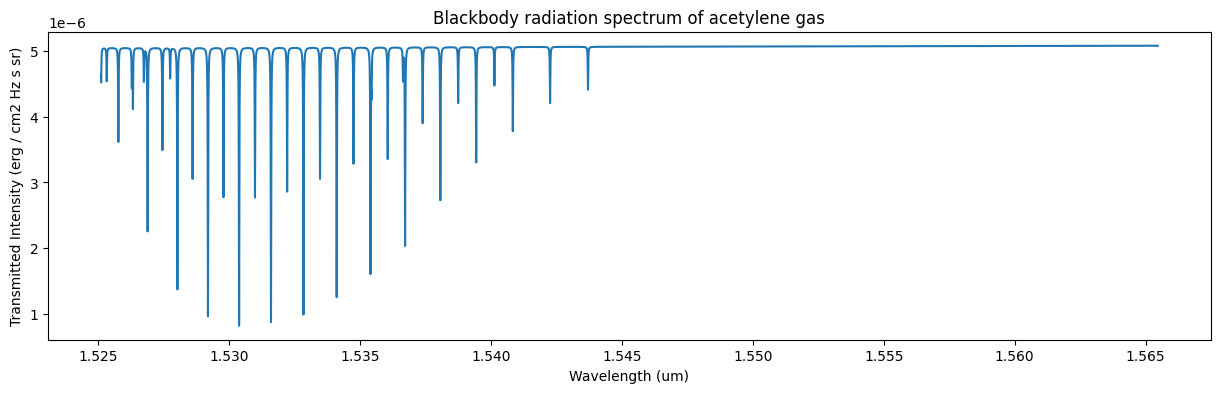

In [9]:
#testing function for plotting blackbody and flux
flux, transmitted_intensity = blackbodyabsorption('acetylene gas', spectra_wav, transmittance, 3000, None, None)


**Simulating stretching of the fibre bragg grating**

In [10]:
#Loading the fibre grating data for the simulation

fibre_wavelength, fibregrating_line_data = input_spectra('/home/samhitasodhi/Gas Sensor Project/Code - Nicholas Morley/fbg_prog/fbg_prog/Line_Lists/FBG_C33-c2h2200C3M_42nm_0_T.txt', None, '\t', 'nm', 0, 'dB', 2)

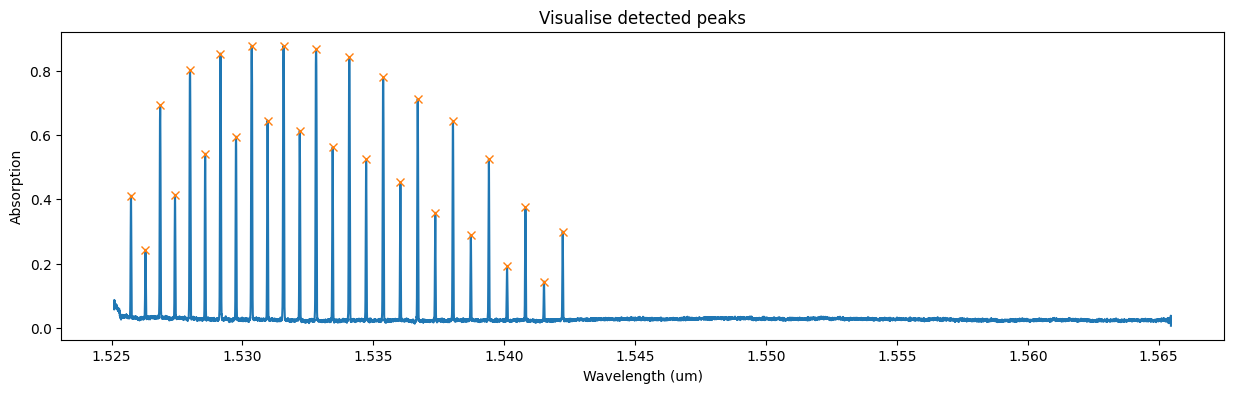

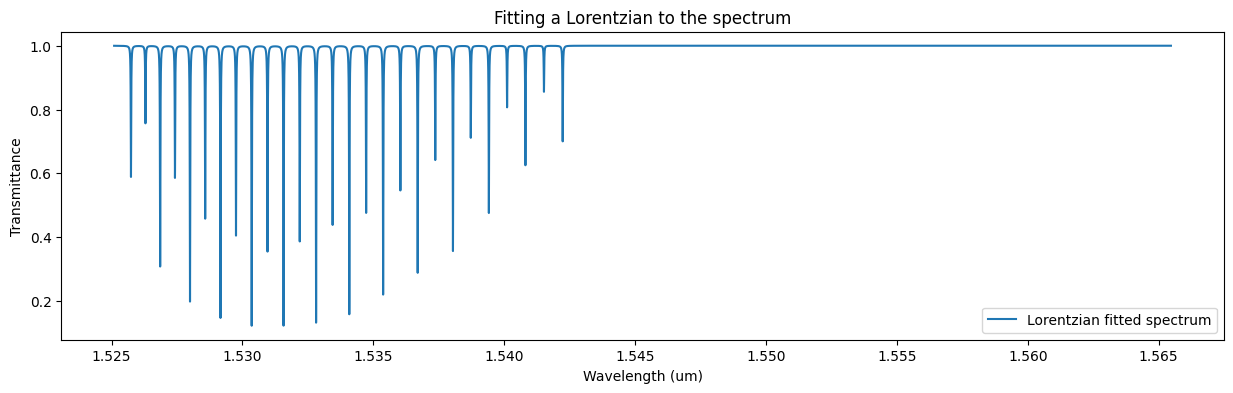

In [11]:
# The following cell models either a gaussian or lorentzian curve to each of the detected peaks from the transmittance spectra - of 
# the fibre bragg grating data. 

transmittanceFBG = fit_curves(fibre_wavelength, fibregrating_line_data, 0.09, None, None, 'lorentzian')

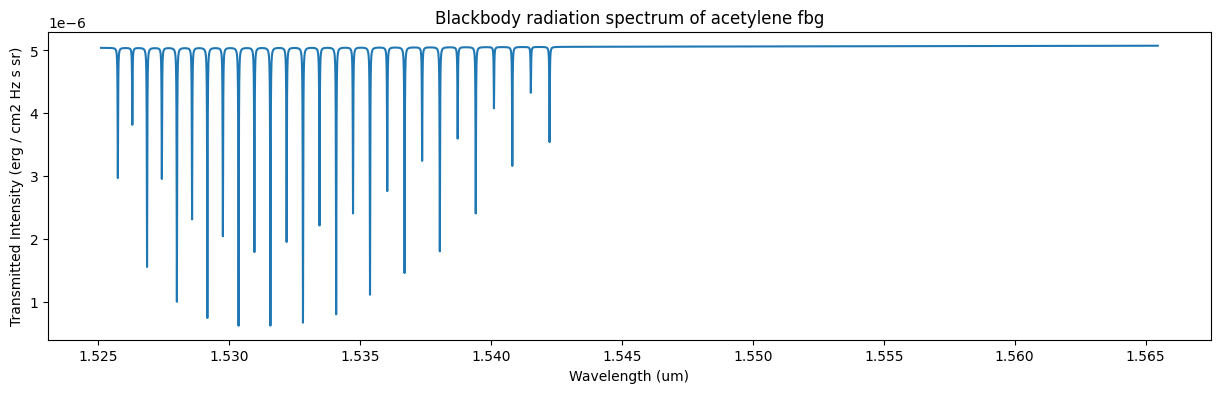

In [12]:
#The following cell incoporates a theoretical blackbody radiation curve to the transmittance spectrum of the FBG. 

fluxFBG, transmitted_intensityFBG = blackbodyabsorption('acetylene fbg', fibre_wavelength, transmittanceFBG, 3000, None, None)

In [25]:
def simulate_strain(name, strain, temp_change, thermal_exp_coeff, thermo_optic_coeff, strain_optic_coeff, xlimits, ylimits):
    """
    This function takes an input of a strain value and simulates the stretching of the fibre bragg grating shown in a plot. It also 
    quantifies the total transmitted and reflected light after the stretching of the Fibre Bragg Grating causing strain.

    Parameters include: 
    - name                : input requires the name of the gas to be in the title of the plot, 
                            i.e., 'carbon dioxide gas' or 'carbon dioxide fibre bragg grating'    
    - strain              : input a single strain value to stretch the fibre bragg grating given in micro-strain values i.e., XXe-6
    - temp_change         : change in temperature in degrees Celsius; 0 for constant temperature
    - thermal_exp_coeff   : thermal expansion coefficient for material of the fibre bragg grating per degree Celsius 
    - thermo_optic_coeff  : thermo-optic coefficient for material of the fibre bragg grating per degree Celsius
    - strain_optic_coeff  : effective strain-optic coefficient of the fibre 
    - xlimits             : user has a choice to input a range of x values (wavelength) i.e.,  [ , ] for the plot
    - ylimits             : user has a choice to input a range of y values (Transmitted Intensity) i.e.,  [ , ] for the plot

    Equation used to simulate wavelength change: wav_shift = (1 - pe)*strain + (alpha + nu)*t_shift 
      (assumes stretching of the grating due to strain and temperature).
    """

    t_shift = temp_change 
    alpha = thermal_exp_coeff
    nu = thermo_optic_coeff 
    pe = strain_optic_coeff 

    wav_shift = (1 - pe)*strain + (alpha + nu)*t_shift
    fibre_wavelength_new = spectra_wav + wav_shift*spectra_wav #creates new wavelengths for which there is no existing data 
    f1 = interp1d(fibre_wavelength_new, transmitted_intensityFBG, bounds_error=False) #extrapolating the datapoints, bounds_error = False -> then interp1d sets the out-of-range values with the fill_value, which is nan by default
    interpolatedvals = f1(fibre_wavelength)
    
    # Plotting the different curves 
    if xlimits is not None or ylimits is not None: 
      # Plot with custom limits
      figure(figsize=(15, 4))
      plt.plot(fibre_wavelength_new, interpolatedvals, ls='dashed', c = 'red', label = 'Strained FBG spectra')
      plt.plot(spectra_wav, transmitted_intensity, alpha = 0.6, c = 'b', label = 'Original gas spectra')
      plt.plot(fibre_wavelength, transmitted_intensityFBG, alpha = 0.6, c = 'y', label = 'Original FBG spectra')
      plt.xlim(xlimits)
      plt.ylim(ylimits)
      plt.legend(loc = 'lower right')
      plt.title('Straining the Fiber Bragg Grating for' + ' ' + name)
      plt.xlabel('Wavelength (um)')
      plt.ylabel('Transmitted Intensity (erg / cm2 Hz s sr)')
      plt.show()
      
    else: 
      # Plot without custom limits
      figure(figsize=(15, 4))
      plt.plot(fibre_wavelength_new, interpolatedvals, ls='dashed', c = 'red', label = 'Strained FBG spectra')
      plt.plot(spectra_wav, transmitted_intensity, alpha = 0.6, c = 'b', label = 'Original gas spectra')
      plt.plot(fibre_wavelength, transmitted_intensityFBG, alpha = 0.6, c = 'y', label = 'Original FBG spectra')
      plt.legend(loc = 'lower right')
      plt.title('Straining the Fiber Bragg Grating for' + ' ' + name)
      plt.xlabel('Wavelength (um)')
      plt.ylabel('Transmitted Intensity (erg / cm2 Hz s sr)')
      plt.show()

    # ~~~~~ Finding the overall effect of straining the fibre 
    #For transmitted light
    strainedtransmittedlight = np.array(1-interpolatedvals*spectra_data)     # strained x original gas data "above" curve = transmitted light
    remove_nans_trans = np.isnan(strainedtransmittedlight)
    trans_without_nan = strainedtransmittedlight[~remove_nans_trans]
    trans = np.sum(trans_without_nan)
    
    #For reflected light
    strainedreflectedlight = np.array(interpolatedvals*spectra_data)
    remove_nans_refl = np.isnan(strainedreflectedlight)
    refl_without_nan = strainedreflectedlight[~remove_nans_refl]
    refl = np.sum(refl_without_nan)

    print('Total Transmitted Light (erg / cm2 Hz s sr):', trans) 
    print('Total Reflected Light (erg / cm2 Hz s sr):', refl) 
    
    return fibre_wavelength_new, interpolatedvals
    

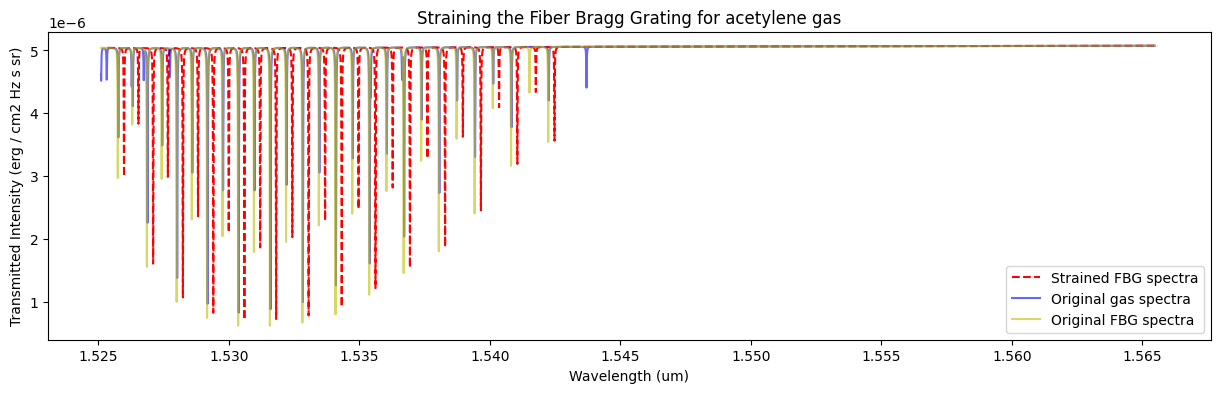

Total Transmitted Light (erg / cm2 Hz s sr): 16313.921531880918
Total Reflected Light (erg / cm2 Hz s sr): 0.07846811908145424


In [26]:
#testing the straining function

fibre_wavelength_new, interpolatedvals = simulate_strain('acetylene gas', 1e-4, 0, 0.55e-6, 8.6e-6, 0.22, None, None) #values for silica, no temperature change

In [15]:
def plot_total_light(strain_values, temp_change, thermal_exp_coeff, thermo_optic_coeff, strain_optic_coeff, xlimits, ylimits):
    """
    This function takes the same parameters as simulate_strain but plots a graph of the total light transmitted and reflected at several 
    strain values in (erg / cm2 Hz s sr) after conducting the simulation for each strain value. 

    Parameters include:
    - strain_values       : input a range of strain values to stretch the fibre bragg grating 
                            i.e., strain_values = np.linspace(XXe-6, XXe-4)
    - temp_change         : change in temperature in degrees Celsius; 0 for constant temperature
    - thermal_exp_coeff   : thermal expansion coefficient for material of the fibre bragg grating per degree Celsius 
    - thermo_optic_coeff  : thermo-optic coefficient for material of the fibre bragg grating per degree Celsius
    - strain_optic_coeff  : effective strain-optic coefficient of the fibre 
    - xlimits             : user has a choice to input a range of x values (wavelength) i.e.,  [ , ] for the plot
    - ylimits             : user has a choice to input a range of y values (Transmitted Intensity) i.e.,  [ , ] for the plot
    """
    
    # ~~~~~ Plotting transmitted/reflected light for different strain values
    strain = strain_values
    t_shift = temp_change 
    alpha = thermal_exp_coeff
    nu = thermo_optic_coeff 
    pe = strain_optic_coeff 

    trans_append = []
    refl_append = []

    for i in strain:
        wav_shift = (1 - pe)*i + (alpha + nu)*t_shift
        fibre_wavelength_new = spectra_wav + wav_shift*spectra_wav #creates new wavelengths for which there is no existing data 
        f1 = interp1d(fibre_wavelength_new, transmitted_intensityFBG, bounds_error=False) #extrapolating the datapoints, bounds_error = False -> then interp1d sets the out-of-range values with the fill_value, which is nan by default
        interpolatedvals = f1(fibre_wavelength)

        #For transmitted light
        strainedtransmittedlight = np.array(1-interpolatedvals*spectra_data)    
        remove_nans_trans = np.isnan(strainedtransmittedlight)
        trans_without_nan = strainedtransmittedlight[~remove_nans_trans]
        trans = np.sum(trans_without_nan)
        trans_append = np.append(trans_append, trans)

        #For reflected light
        strainedreflectedlight = np.array(interpolatedvals*spectra_data)
        remove_nans_refl = np.isnan(strainedreflectedlight)
        refl_without_nan = strainedreflectedlight[~remove_nans_refl]
        refl = np.sum(refl_without_nan)
        refl_append = np.append(refl_append, refl)
    
    if xlimits is not None or ylimits is not None: 
      # Plot with custom limits
        figure(figsize=(15, 4))
        plt.plot(strain, trans_append) 
        plt.xlabel('Strain')
        plt.ylabel('Total Transmitted Light (erg / cm2 Hz s sr)')
        plt.xlim(xlimits)
        plt.ylim(ylimits)
        plt.title('Total Transmitted Light through the Fibre Bragg Grating after strain')
        plt.show()
        
        figure(figsize=(15, 4))
        plt.plot(strain, refl_append) 
        plt.xlabel('Strain')
        plt.ylabel('Total Reflected Light (erg / cm2 Hz s sr)')
        plt.xlim(xlimits)
        plt.ylim(ylimits)
        plt.title('Total Reflected Light through the Fibre Bragg Grating after strain')
        plt.show()
    else:
        # Plot without custom limits
        figure(figsize=(15, 4))
        plt.plot(strain, trans_append)  
        plt.xlabel('Strain')
        plt.ylabel('Total Transmitted Light (erg / cm2 Hz s sr)')
        plt.title('Total Transmitted Light through the Fibre Bragg Grating after strain')
        plt.show()

        figure(figsize=(15, 4))
        plt.plot(strain, refl_append) 
        plt.xlabel('Strain')
        plt.ylabel('Total Reflected Light (erg / cm2 Hz s sr)')
        plt.title('Total Reflected Light through the Fibre Bragg Grating after strain')
        plt.show()
    
    return 

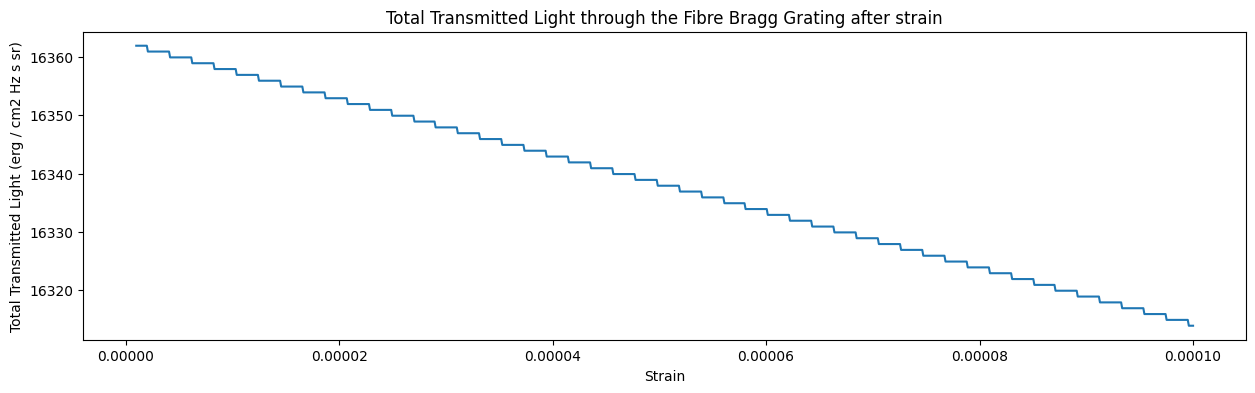

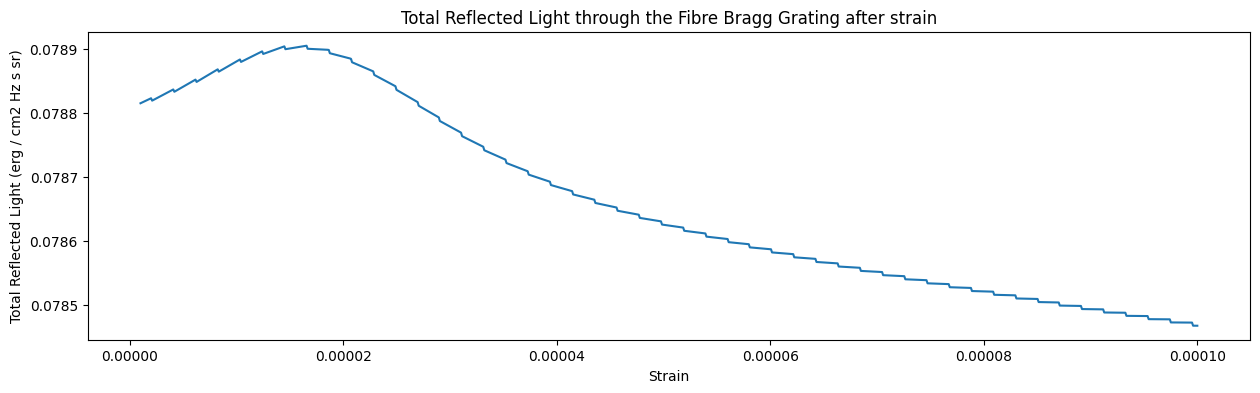

In [28]:
#Testing plot_total_light for several strain values 

#strain = np.linspace(1e-6, 1e-4) #plots look smoother, trans has a weird bump near ~0.00004 
strain = np.linspace(1e-6, 1e-4, 1000) #weird zigzag lines but overall same trend for both graphs

plot_total_light(strain, 0, 0.55e-6, 8.6e-6, 0.22, None, None)

In [17]:
def convert_fluxunits_to_photoncounts(name, wavelength, flux, emission_coefficient, area, solid_angle, xlimits, ylimits):
    """
    Function converts the units from flux values erg /(cm2 Hz s sr) to photon counts (photons/sec) and plots a graph. 
    
    Parameters: 
        - name                  : input requires the name of the gas to be in the title of the plot, 
                                  i.e., 'carbon dioxide gas' or 'carbon dioxide fibre bragg grating'
        - wavelength            : loads in the wavelengths (um)
        - flux                  : input flux value to be converted into photon counts. Must be in erg /(cm2 Hz s sr)!
        - emisson_coefficient   : requires the emission coefficient of the light source filament at a particular temperature 
        - area                  : area of the fibre cross-section (cm^2)
        - solid_angle           : solid angle (steradians) that reaches the fibre core of a particular 
                                  diameter
        - xlimits               : user has a choice to input a range of x values (wavelength) i.e.,  [ , ] for the plot
        - ylimits               : user has a choice to input a range of y values (Transmitted Intensity) i.e.,  [ , ] for the plot
    """
    tc = emission_coefficient
    A = area 
    sr = solid_angle 
    c = const.c.value
    h = const.h.value
    unitless_flux = flux 
    frequency = c/(wavelength*(10**(-6))) #calculates the frequency by first converting the wavelength to metres from um
    energy = h*c*frequency
    new_flux = unitless_flux*10**(-7) #such that erg /(cm2 Hz s sr) --> J /(cm2 Hz s sr)
    
    photoncount_persec = (tc*new_flux*A*sr*frequency)/energy # output units in sphotons per sec 

    if xlimits is not None or ylimits is not None: 
      # Plot with custom limits
        figure(figsize=(15, 4))
        plt.plot(wavelength, photoncount_persec)
        plt.title('Photon counts (per sec) for' + ' ' + name)
        plt.xlim(xlimits)
        plt.ylim(ylimits)
        plt.xlabel('Wavelength (um)')
        plt.ylabel('Photons / sec')
        plt.show()
    else:
        # Plot without custom limits
        figure(figsize=(15, 4))
        plt.plot(wavelength, photoncount_persec)
        plt.title('Photon counts (per sec) for' + ' ' + name)
        plt.xlabel('Wavelength (um)')
        plt.ylabel('Photons / sec')
        plt.show()

    return photoncount_persec

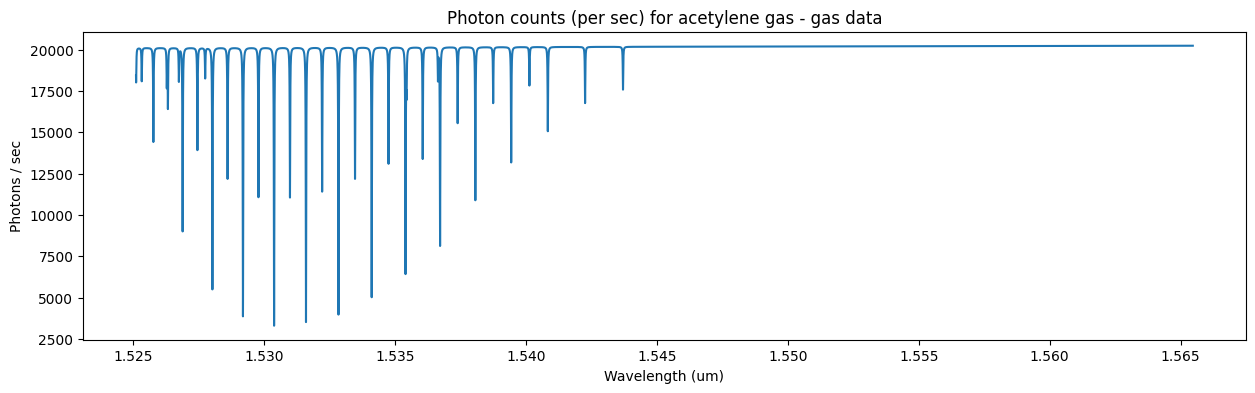

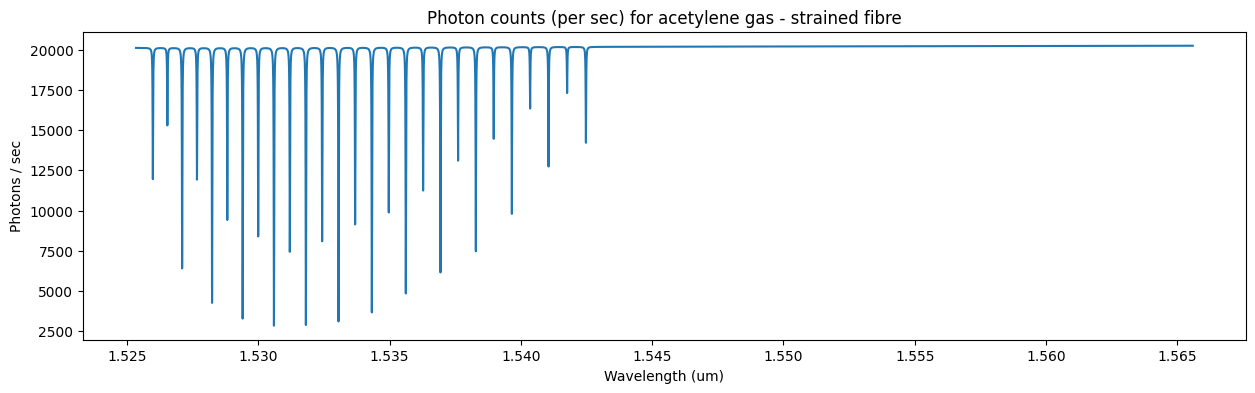

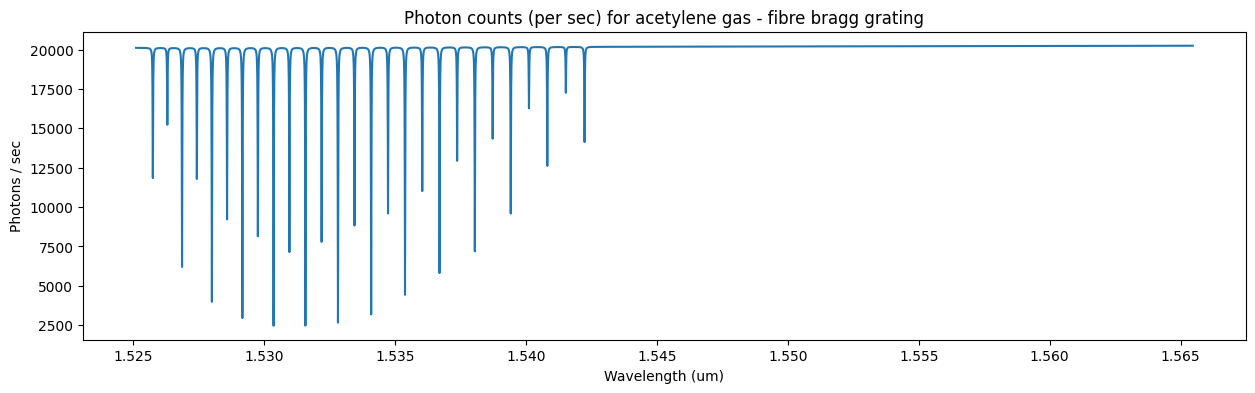

In [18]:
#testing unit conversion function

photoncount_persec = convert_fluxunits_to_photoncounts('acetylene gas - gas data', spectra_wav, transmitted_intensity, 0.35, 0.000000503, 0.045, None, None)
photoncount_persec = convert_fluxunits_to_photoncounts('acetylene gas - strained fibre', fibre_wavelength_new, interpolatedvals, 0.35, 0.000000503, 0.045, None, None)
photoncount_persec = convert_fluxunits_to_photoncounts('acetylene gas - fibre bragg grating', fibre_wavelength, transmitted_intensityFBG, 0.35, 0.000000503, 0.045, None, None)
